In [1]:
import xarray as xr
import pandas as pd
data_temp = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Temp\*.nc", parallel=False)
data_tmax = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmax\*.nc", parallel=False)
data_tmin = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmin\*.nc", parallel=False)
data_rain = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Rain\*.nc", parallel=False)
data_hurs = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Humidity\*.nc", parallel=False)
data_sun = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Sun\*.nc", parallel=False)
data_frost = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Frost\*.nc", parallel=False)
data_psl = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_psl\*.nc", parallel=False)
data_wind = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Wind\*.nc", parallel=False)

In [2]:
import numpy as np

rain = np.array(data_rain['rainfall'])
hurs = np.array(data_hurs['hurs'])
temp = np.array(data_temp['tas'])
temp_max = np.array(data_tmax['tasmax'])
temp_min = np.array(data_tmin['tasmin'])
sun = np.array(data_sun['sun'])
frost = np.array(data_frost['groundfrost'])
psl = np.array(data_psl['psl'])
wind = np.array(data_wind['sfcWind'])

min_length = len(wind)
rain = rain[:min_length]
hurs = hurs[:min_length]
temp = temp[:min_length]
temp_max = temp_max[:min_length]
temp_min = temp_min[:min_length]
sun = sun[:min_length]
frost = frost[:min_length]
wind = wind[:min_length]
psl = psl[:min_length]

In [3]:
import torch 

land_mask = ~np.isnan(temp)
land_mask_torch = torch.from_numpy(land_mask.astype(bool)) 

print(temp.shape)
print(land_mask.shape)

(648, 112, 82)
(648, 112, 82)


In [4]:
from skimage import measure

# Connected components labeling
labels = measure.label(land_mask)
biggest_component_label = np.argmax(np.bincount(labels.flat)[1:]) + 1  

# Isolate the biggest component
main_landmass_mask = (labels == biggest_component_label) 

# Get indices for bounding box
nonzero_indices = main_landmass_mask.nonzero()
min_row = np.min(nonzero_indices[1])
max_row = np.max(nonzero_indices[1])
min_col = np.min(nonzero_indices[2])
max_col = np.max(nonzero_indices[2])

In [5]:
rain = rain[:, min_row:max_row + 1, min_col:max_col + 1]
hurs = hurs[:, min_row:max_row + 1, min_col:max_col + 1]
temp = temp[:, min_row:max_row + 1, min_col:max_col + 1]
temp_max = temp_max[:, min_row:max_row + 1, min_col:max_col + 1]
temp_min = temp_min[:, min_row:max_row + 1, min_col:max_col + 1]
sun = sun[:, min_row:max_row + 1, min_col:max_col + 1] 
frost = frost[:, min_row:max_row + 1, min_col:max_col + 1] 
psl = psl[:, min_row:max_row + 1, min_col:max_col + 1] 
wind = wind[:, min_row:max_row + 1, min_col:max_col + 1] 
land_mask = land_mask[:, min_row:max_row + 1, min_col:max_col + 1]

In [6]:
nan_counts = np.count_nonzero(np.isnan(rain), axis=0)  # Counts across time

valid_grid_cell_mask = nan_counts == 0
valid_cell_indices = np.where(valid_grid_cell_mask)

# Your arrays from the previous output:
row_indices = valid_cell_indices[0]
col_indices = valid_cell_indices[1]

unique_rows, row_counts = np.unique(row_indices, return_counts=True)
unique_cols, col_counts = np.unique(col_indices, return_counts=True)

In [7]:
valid_row_indices = valid_cell_indices[0]  # Extract row indices
valid_col_indices = valid_cell_indices[1]  # Extract column indices

valid_rain_data = rain[:, valid_row_indices, valid_col_indices]
valid_temp_data = temp[:, valid_row_indices, valid_col_indices]
valid_wind_data = wind[:, valid_row_indices, valid_col_indices]
valid_hurs_data = hurs[:, valid_row_indices, valid_col_indices]
valid_psl_data = psl[:, valid_row_indices, valid_col_indices]
valid_frost_data = frost[:, valid_row_indices, valid_col_indices]
valid_sun_data = sun[:, valid_row_indices, valid_col_indices]
valid_tmax_data = temp_max[:, valid_row_indices, valid_col_indices]
valid_tmin_data = temp_min[:, valid_row_indices, valid_col_indices]

In [8]:
valid_rain_data = valid_rain_data[:,:1600].reshape(648, 64, 25)
valid_temp_data = valid_temp_data[:,:1600].reshape(648, 64, 25)
valid_wind_data = valid_wind_data[:,:1600].reshape(648, 64, 25)
valid_hurs_data = valid_hurs_data[:,:1600].reshape(648, 64, 25)
valid_psl_data = valid_psl_data[:,:1600].reshape(648, 64, 25)
valid_sun_data = valid_sun_data[:,:1600].reshape(648, 64, 25)
valid_frost_data = valid_frost_data[:,:1600].reshape(648, 64, 25)
valid_tmax_data = valid_tmax_data[:,:1600].reshape(648, 64, 25)
valid_tmin_data = valid_tmin_data[:,:1600].reshape(648, 64, 25)

In [9]:
nan_count_temp = np.isnan(valid_temp_data).sum()
nan_count_tmax = np.isnan(valid_tmax_data).sum()
nan_count_tmin = np.isnan(valid_tmin_data).sum()
nan_count_wind = np.isnan(valid_wind_data).sum()

print('Number of NaN values in Temp:', nan_count_temp)
print('Number of NaN values in Tmax:', nan_count_tmax)
print('Number of NaN values in Tmin:', nan_count_tmin)
print('Number of NaN values in Wind:', nan_count_wind)


def fill_nan_with_mean(data):
    col_mean = np.nanmean(data, axis=0)  # Calculate mean per column
    inds = np.where(np.isnan(data))
    data[inds] = np.take(col_mean, inds[1])  # Replace NaNs with mean
    return data

temp_filled = fill_nan_with_mean(valid_temp_data.copy())  
tmax_filled = fill_nan_with_mean(valid_tmax_data.copy())
tmin_filled = fill_nan_with_mean(valid_tmin_data.copy())
wind_filled = fill_nan_with_mean(valid_wind_data.copy())

nan_count_temp = np.isnan(temp_filled).sum()
nan_count_tmax = np.isnan(tmax_filled).sum()
nan_count_tmin = np.isnan(tmin_filled).sum()
nan_count_wind = np.isnan(wind_filled).sum()

print('Number of NaN values in Temp:', nan_count_temp)
print('Number of NaN values in Tmax:', nan_count_tmax)
print('Number of NaN values in Tmin:', nan_count_tmin)
print('Number of NaN values in Tmin:', nan_count_tmin)

Number of NaN values in Temp: 123
Number of NaN values in Tmax: 108
Number of NaN values in Tmin: 123
Number of NaN values in Wind: 167
Number of NaN values in Temp: 0
Number of NaN values in Tmax: 0
Number of NaN values in Tmin: 0
Number of NaN values in Tmin: 0


In [10]:
rain_tensor = torch.from_numpy(valid_rain_data)
temp_tensor = torch.from_numpy(temp_filled)
hurs_tensor = torch.from_numpy(valid_hurs_data)
frost_tensor = torch.from_numpy(valid_frost_data)
sun_tensor = torch.from_numpy(valid_sun_data)
wind_tensor = torch.from_numpy(wind_filled)
psl_tensor = torch.from_numpy(valid_psl_data)
tmax_tensor = torch.from_numpy(tmax_filled)
tmin_tensor = torch.from_numpy(tmin_filled)

In [11]:
variables = [rain_tensor, temp_tensor, hurs_tensor, frost_tensor, sun_tensor, wind_tensor, psl_tensor, tmax_tensor, tmin_tensor] 

# Stack along the channels dimension (dim=1)
stacked_tensor = torch.stack(variables, dim=1) 

stacked_array = stacked_tensor.numpy() 
print('Stacked array shape:', stacked_array.shape)

Stacked array shape: (648, 9, 64, 25)


In [12]:
from convlstm import ConvLSTM
import torch  

seq_length = 12
num_layers = 1  
hidden_dim = [64]
kernel_size = [(3,3)]  
input_channels = 9   

model = ConvLSTM(input_dim=input_channels,
                    hidden_dim=hidden_dim,
                    kernel_size=kernel_size,
                    num_layers=num_layers,
                    batch_first=True,  
                    return_all_layers=False)

In [13]:
def create_input_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i+seq_length]  # Shape: (seq_length, 9, 64, 25)
        sequences.append(sequence)
    return np.array(sequences)

def create_target_sequences(data, seq_length, forecast_length):
    targets = []
    for i in range(len(data) - seq_length - forecast_length + 1):
        # Adjust this line to gather a sequence of 'forecast_length' future frames as the target
        target = data[i + seq_length:i + seq_length + forecast_length, 1, :, :]
        targets.append(target)
    return np.array(targets)

seq_length = 12  # This represents how many timesteps back the model should look
forecast_length = 12
# Assuming stacked_array is your input data with shape (648, 9, 64, 25)
input_sequences = create_input_sequences(stacked_array, seq_length)
target_sequences = create_target_sequences(stacked_array, seq_length, forecast_length)

input_sequences = input_sequences[:625]

# Check the shapes to ensure everything looks right
print("Input sequences shape:", input_sequences.shape)
print("Target sequences shape:", target_sequences.shape)

Input sequences shape: (625, 12, 9, 64, 25)
Target sequences shape: (625, 12, 64, 25)


In [14]:
import torch

# Convert numpy arrays to PyTorch tensors
input_sequences_tensor = torch.tensor(input_sequences, dtype=torch.float)
target_sequences_tensor = torch.tensor(target_sequences, dtype=torch.float)

# Add a channel dimension to the target tensor to match the expected input shape of the model
target_sequences_tensor = target_sequences_tensor.unsqueeze(2)  

print("Input tensor shape:", input_sequences_tensor.shape)
print("Target tensor shape:", target_sequences_tensor.shape)

Input tensor shape: torch.Size([625, 12, 9, 64, 25])
Target tensor shape: torch.Size([625, 12, 1, 64, 25])


In [15]:
from sklearn.model_selection import train_test_split

inputs_temp, inputs_test, targets_temp, targets_test = train_test_split(
    input_sequences_tensor, target_sequences_tensor, test_size=0.2, random_state=42
)

inputs_train, inputs_val, targets_train, targets_val = train_test_split(
    inputs_temp, targets_temp, test_size=0.25, random_state=42  
)

print("Training set shapes:", inputs_train.shape, targets_train.shape)
print("Validation set shapes:", inputs_val.shape, targets_val.shape)
print("Test set shapes:", inputs_test.shape, targets_test.shape)

Training set shapes: torch.Size([375, 12, 9, 64, 25]) torch.Size([375, 12, 1, 64, 25])
Validation set shapes: torch.Size([125, 12, 9, 64, 25]) torch.Size([125, 12, 1, 64, 25])
Test set shapes: torch.Size([125, 12, 9, 64, 25]) torch.Size([125, 12, 1, 64, 25])


In [ ]:
'''from sklearn.preprocessing import MinMaxScaler

inputs_train = inputs_train.reshape(-1, 1)
inputs_val = inputs_val.reshape(-1, 1)
inputs_test = inputs_test.reshape(-1, 1)
targets_train = targets_train.reshape(-1, 1)
targets_val = targets_val.reshape(-1, 1)
targets_test = targets_test.reshape(-1, 1)

scaler = MinMaxScaler()
scaler.fit(inputs_train) 

X_train_scaled = scaler.transform(inputs_train)
X_val_scaled = scaler.transform(inputs_val)
X_test_scaled = scaler.transform(inputs_test)
y_train_scaled = scaler.transform(targets_train)
y_val_scaled = scaler.transform(targets_val)
y_test_scaled = scaler.transform(targets_test)

X_train_scaled = X_train_scaled.reshape(375, 12, 9, 64, 25)
X_val_scaled = X_val_scaled.reshape(125, 12, 9, 64, 25)
X_test_scaled = X_test_scaled.reshape(125, 12, 9, 64, 25)
y_train_scaled = y_train_scaled.reshape(375, 12, 1, 64, 25)
y_val_scaled = y_val_scaled.reshape(125, 12, 1, 64, 25)
y_test_scaled = y_test_scaled.reshape(125, 12, 1, 64, 25)

X_train_scaled_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_scaled_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_scaled_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_scaled_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
y_val_scaled_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)
y_test_scaled_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)'''

In [16]:
from torch.utils.data import DataLoader, TensorDataset

# Create TensorDatasets
train_data = TensorDataset(inputs_train, targets_train)
val_data = TensorDataset(inputs_val, targets_val)
test_data = TensorDataset(inputs_test, targets_test)
print(f"Prepared Train Dataset Size: {len(train_data)} samples")
print(f"Prepared Validation Dataset Size: {len(val_data)} samples")
print(f"Prepared Test Dataset Size: {len(test_data)} samples")
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
print(f"Train DataLoader Length: {len(train_loader)} batches")
print(f"Validation DataLoader Length: {len(val_loader)} batches")
print(f"Test DataLoader Length: {len(test_loader)} batches")

Prepared Train Dataset Size: 375 samples
Prepared Validation Dataset Size: 125 samples
Prepared Test Dataset Size: 125 samples
Train DataLoader Length: 12 batches
Validation DataLoader Length: 4 batches
Test DataLoader Length: 4 batches


Epoch: 1/300, Train Loss: 130.7537, Val Loss: 57.5334, Train R2: -2.1475, Val R2: -1.9838, Train MAE: 6.4429, Val MAE: 6.2277
Epoch: 2/300, Train Loss: 106.4311, Val Loss: 48.8662, Train R2: -1.6699, Val R2: -1.5276, Train MAE: 5.8102, Val MAE: 5.6132
Epoch: 3/300, Train Loss: 89.5631, Val Loss: 41.9794, Train R2: -1.2432, Val R2: -1.1664, Train MAE: 5.2382, Val MAE: 5.1290
Epoch: 4/300, Train Loss: 78.1584, Val Loss: 37.0105, Train R2: -0.9636, Val R2: -0.9066, Train MAE: 4.8706, Val MAE: 4.7912
Epoch: 5/300, Train Loss: 69.3313, Val Loss: 33.1006, Train R2: -0.7462, Val R2: -0.7028, Train MAE: 4.5934, Val MAE: 4.5396
Epoch: 6/300, Train Loss: 62.4008, Val Loss: 30.0466, Train R2: -0.5764, Val R2: -0.5443, Train MAE: 4.3870, Val MAE: 4.3547
Epoch: 7/300, Train Loss: 57.0178, Val Loss: 27.6788, Train R2: -0.4456, Val R2: -0.4221, Train MAE: 4.2357, Val MAE: 4.2195
Epoch: 8/300, Train Loss: 52.8796, Val Loss: 25.8689, Train R2: -0.3459, Val R2: -0.3292, Train MAE: 4.1260, Val MAE: 4.123

Epoch: 67/300, Train Loss: 29.4266, Val Loss: 14.7349, Train R2: 0.2350, Val R2: 0.2371, Train MAE: 3.1967, Val MAE: 3.2144
Epoch: 68/300, Train Loss: 28.9662, Val Loss: 14.5550, Train R2: 0.2466, Val R2: 0.2469, Train MAE: 3.1698, Val MAE: 3.1910
Epoch: 69/300, Train Loss: 28.6382, Val Loss: 14.3861, Train R2: 0.2554, Val R2: 0.2556, Train MAE: 3.1486, Val MAE: 3.1685
Epoch: 70/300, Train Loss: 28.2639, Val Loss: 14.2206, Train R2: 0.2651, Val R2: 0.2643, Train MAE: 3.1228, Val MAE: 3.1441
Epoch: 71/300, Train Loss: 27.9466, Val Loss: 14.0659, Train R2: 0.2735, Val R2: 0.2727, Train MAE: 3.1014, Val MAE: 3.1230
Epoch: 72/300, Train Loss: 27.6180, Val Loss: 13.8969, Train R2: 0.2815, Val R2: 0.2812, Train MAE: 3.0818, Val MAE: 3.1020
Epoch: 73/300, Train Loss: 27.2807, Val Loss: 13.7185, Train R2: 0.2911, Val R2: 0.2908, Train MAE: 3.0580, Val MAE: 3.0778
Epoch: 74/300, Train Loss: 26.6770, Val Loss: 13.0432, Train R2: 0.3163, Val R2: 0.3266, Train MAE: 2.9960, Val MAE: 2.9879
Epoch: 7

Epoch: 134/300, Train Loss: 11.2378, Val Loss: 5.7420, Train R2: 0.7093, Val R2: 0.7045, Train MAE: 1.8600, Val MAE: 1.8919
Epoch: 135/300, Train Loss: 11.1784, Val Loss: 5.5617, Train R2: 0.7109, Val R2: 0.7145, Train MAE: 1.8515, Val MAE: 1.8563
Epoch: 136/300, Train Loss: 10.9888, Val Loss: 5.6821, Train R2: 0.7156, Val R2: 0.7078, Train MAE: 1.8395, Val MAE: 1.8859
Epoch: 137/300, Train Loss: 10.9338, Val Loss: 5.4737, Train R2: 0.7170, Val R2: 0.7192, Train MAE: 1.8331, Val MAE: 1.8453
Epoch: 138/300, Train Loss: 10.7735, Val Loss: 5.4709, Train R2: 0.7208, Val R2: 0.7190, Train MAE: 1.8196, Val MAE: 1.8406
Epoch: 139/300, Train Loss: 10.6491, Val Loss: 5.4251, Train R2: 0.7235, Val R2: 0.7208, Train MAE: 1.8094, Val MAE: 1.8309
Epoch: 140/300, Train Loss: 10.5478, Val Loss: 5.3896, Train R2: 0.7274, Val R2: 0.7232, Train MAE: 1.7969, Val MAE: 1.8268
Epoch: 141/300, Train Loss: 10.4612, Val Loss: 5.2267, Train R2: 0.7294, Val R2: 0.7316, Train MAE: 1.7915, Val MAE: 1.7947
Epoch: 1

Epoch: 201/300, Train Loss: 6.9721, Val Loss: 3.5483, Train R2: 0.8174, Val R2: 0.8167, Train MAE: 1.4678, Val MAE: 1.4842
Epoch: 202/300, Train Loss: 6.8880, Val Loss: 3.5005, Train R2: 0.8191, Val R2: 0.8187, Train MAE: 1.4578, Val MAE: 1.4749
Epoch: 203/300, Train Loss: 6.8670, Val Loss: 3.5025, Train R2: 0.8224, Val R2: 0.8186, Train MAE: 1.4451, Val MAE: 1.4723
Epoch: 204/300, Train Loss: 6.7746, Val Loss: 3.4248, Train R2: 0.8229, Val R2: 0.8224, Train MAE: 1.4422, Val MAE: 1.4524
Epoch: 205/300, Train Loss: 6.7270, Val Loss: 3.4114, Train R2: 0.8240, Val R2: 0.8230, Train MAE: 1.4421, Val MAE: 1.4522
Epoch: 206/300, Train Loss: 6.6873, Val Loss: 3.4097, Train R2: 0.8257, Val R2: 0.8232, Train MAE: 1.4306, Val MAE: 1.4542
Epoch: 207/300, Train Loss: 6.6191, Val Loss: 3.3802, Train R2: 0.8263, Val R2: 0.8245, Train MAE: 1.4299, Val MAE: 1.4440
Epoch: 208/300, Train Loss: 6.5982, Val Loss: 3.4390, Train R2: 0.8262, Val R2: 0.8213, Train MAE: 1.4305, Val MAE: 1.4624
Epoch: 209/300, 

Epoch: 268/300, Train Loss: 5.9312, Val Loss: 2.9360, Train R2: 0.8457, Val R2: 0.8460, Train MAE: 1.3528, Val MAE: 1.3554
Epoch: 269/300, Train Loss: 5.8303, Val Loss: 2.9811, Train R2: 0.8446, Val R2: 0.8437, Train MAE: 1.3578, Val MAE: 1.3671
Epoch: 270/300, Train Loss: 5.8733, Val Loss: 3.0209, Train R2: 0.8434, Val R2: 0.8411, Train MAE: 1.3619, Val MAE: 1.3759
Epoch: 271/300, Train Loss: 5.8486, Val Loss: 2.9668, Train R2: 0.8457, Val R2: 0.8443, Train MAE: 1.3486, Val MAE: 1.3651
Epoch: 272/300, Train Loss: 5.8014, Val Loss: 2.9513, Train R2: 0.8471, Val R2: 0.8453, Train MAE: 1.3444, Val MAE: 1.3631
Epoch: 273/300, Train Loss: 5.7896, Val Loss: 3.0596, Train R2: 0.8463, Val R2: 0.8392, Train MAE: 1.3482, Val MAE: 1.3890
Epoch: 274/300, Train Loss: 5.9538, Val Loss: 2.9409, Train R2: 0.8413, Val R2: 0.8458, Train MAE: 1.3735, Val MAE: 1.3575
Epoch: 275/300, Train Loss: 5.8530, Val Loss: 2.9791, Train R2: 0.8448, Val R2: 0.8436, Train MAE: 1.3571, Val MAE: 1.3689
Epoch: 276/300, 

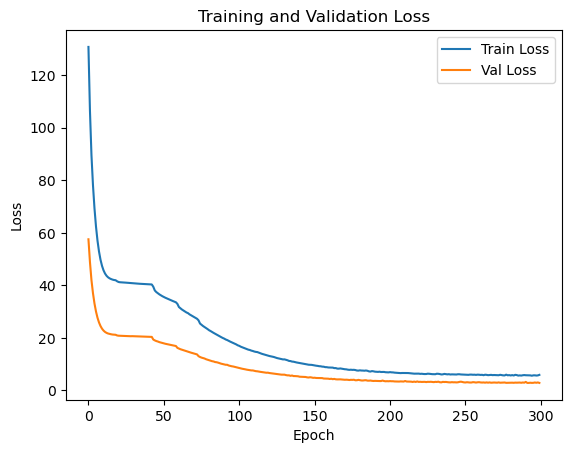

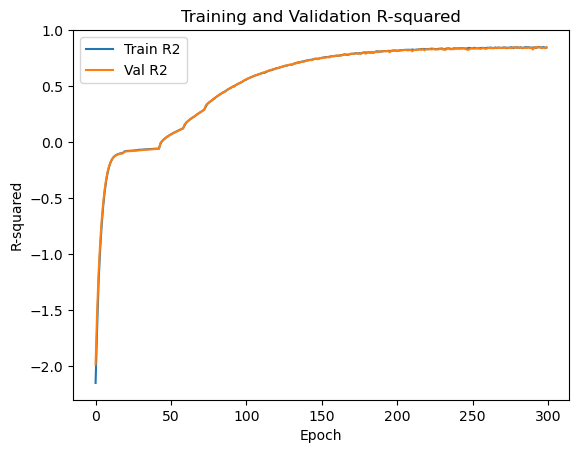

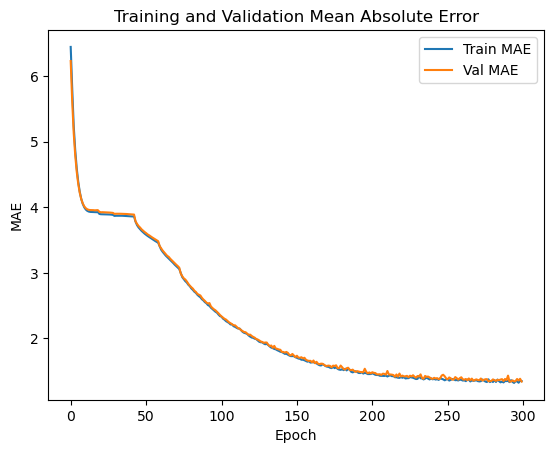

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score, mean_absolute_error

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define number of epochs
num_epochs = 300

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Lists to store R-squared values and MAE
train_r2_scores = []
val_r2_scores = []
train_maes = []
val_maes = []

# Training loop
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        
        optimizer.zero_grad()
        outputs = model(inputs)

        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        
    predictions_train = []
    targets_train = []
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        
        # Collect predictions and targets for calculating R-squared and MAE
        predictions_train.append(outputs.detach().numpy())
        targets_train.append(targets.numpy())
    
    # Calculate R-squared and MAE for training set
    predictions_train = np.concatenate(predictions_train)
    predictions_train = predictions_train.reshape(predictions_train.shape[0], -1)
    targets_train = np.concatenate(targets_train)
    targets_train = targets_train.reshape(targets_train.shape[0], -1)
    train_r2 = r2_score(targets_train, predictions_train)
    train_mae = mean_absolute_error(targets_train, predictions_train)
    
    # Calculate average training loss
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2)
    train_maes.append(train_mae)
    
    # Validation
    model.eval()
    val_loss = 0.0
    predictions_val = []
    targets_val = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            
            # Collect predictions and targets for calculating R-squared and MAE
            predictions_val.append(outputs.detach().numpy())
            targets_val.append(targets.numpy())
    
    # Calculate R-squared and MAE for validation set
    predictions_val = np.concatenate(predictions_val)
    predictions_val = predictions_val.reshape(predictions_val.shape[0], -1)
    targets_val = np.concatenate(targets_val)
    targets_val = targets_val.reshape(targets_val.shape[0], -1)
    val_r2 = r2_score(targets_val, predictions_val)
    val_mae = mean_absolute_error(targets_val, predictions_val)
    
    # Calculate average validation loss
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_r2_scores.append(val_r2)
    val_maes.append(val_mae)
    
    # Print training/validation statistics
    print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train R2: {train_r2:.4f}, Val R2: {val_r2:.4f}, Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}')

# Plotting loss and metrics
import matplotlib.pyplot as plt

# Loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# R-squared
plt.plot(train_r2_scores, label='Train R2')
plt.plot(val_r2_scores, label='Val R2')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.title('Training and Validation R-squared')
plt.legend()
plt.show()

# MAE
plt.plot(train_maes, label='Train MAE')
plt.plot(val_maes, label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training and Validation Mean Absolute Error')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
import torch


model.eval()

with torch.no_grad():
    predictions_test = []
    targets_test = []

    for inputs, targets in test_loader:

        # Generate predictions
        outputs = model(inputs)

        # Store predictions and targets for evaluation
        predictions_test.append(outputs.cpu().numpy())
        targets_test.append(targets.cpu().numpy())

# Concatenate all batches
predictions_test = np.concatenate(predictions_test, axis=0)
targets_test = np.concatenate(targets_test, axis=0)

# Flatten the arrays to make them compatible with scikit-learn metrics
predictions_test_flat = predictions_test.reshape(-1)
targets_test_flat = targets_test.reshape(-1)

# Calculate R² and MAE
test_r2 = r2_score(targets_test_flat, predictions_test_flat)
test_mae = mean_absolute_error(targets_test_flat, predictions_test_flat)

print(f'Test R²: {test_r2:.4f}')
print(f'Test MAE: {test_mae:.4f}')

Test R²: 0.8658
Test MAE: 1.3294


In [38]:
# Assuming you want to plot the sequence of predictions for the first instance in your test set
instance_index = 0  # First instance

actual_seq = targets_test[instance_index, :, feature_index, 12, 12].flatten()  # Actual sequence
pred_seq = predictions_inverse[instance_index, :, feature_index, 12, 12].flatten()  # Predicted sequence

plt.figure(figsize=(10, 6))
plt.plot(actual_seq, label='Actual Temperatures', marker='o')
plt.plot(pred_seq, label='Predicted Temperatures', marker='x')
plt.title('Temperature Forecasting: Actual vs. Predicted')
plt.xlabel('Time Step')
plt.ylabel('Temperature')
plt.legend()
plt.show()

NameError: name 'feature_index' is not defined

In [ ]:
import torch

stacked_tensor = torch.tensor(stacked_array[625:], dtype=torch.float)

Seq_len = 12  

# Extract the last known sequence from your data
last_known_seq = stacked_tensor[-Seq_len:, :, :, :].unsqueeze(0)

# Configuration
num_future_steps = 12  # How many future steps to forecast
temp_index = 1
device = 'cpu'  

# Load your model 
model.to(device)

last_known_seq = last_known_seq.to(device)

# Forecasting loop
predicted_temps = []

with torch.no_grad():  # No gradients needed for inference
    current_seq = last_known_seq.clone()

    for _ in range(num_future_steps):
        # Generate the temperature prediction for the next time step
        next_temp_pred = model(current_seq)[:, temp_index:temp_index+1, :, :]  # Model prediction

        # Assuming next_temp_pred shape is [1, 1, Height, Width]
        # Store the prediction
        predicted_temps.append(next_temp_pred.cpu())

        # Update current_seq for the next prediction
        # Roll the sequence to discard the oldest frame
        current_seq = torch.roll(current_seq, -1, dims=1)
        
        # Insert the new prediction
        current_seq[:, -1, temp_index, :, :] = next_temp_pred.squeeze(1)

# Concatenate the predictions to form a continuous sequence
predicted_sequence = torch.cat(predicted_temps, dim=1)

In [ ]:
inverse_scaler = MinMaxScaler()

# Set the min_ and scale_ attributes directly based on saved values
# For temperature, assuming it's the only feature you're scaling back
inverse_scaler.min_, inverse_scaler.scale_ = scaler.min_[temp_index], scaler.scale_[temp_index]

# Reshape your data if necessary to fit the scaler's expected input shape
predicted_temps_reshaped = predicted_sequence.reshape(-1, 1)  # Reshape to [n_samples, n_features]

# Apply inverse transformation
denormalized_temps = inverse_scaler.inverse_transform(predicted_temps_reshaped)

# Reshape back to original predicted sequence shape if necessary
denormalized_sequence = denormalized_temps.reshape(1, 12, 1, 64, 25)

In [ ]:
import matplotlib.pyplot as plt

# Assuming the first time step of the first predicted map is what you want to visualize
temperature_map = predicted_sequence[0, 0, 0]  # Convert to NumPy array for visualization

plt.imshow(temperature_map, cmap='hot')
plt.colorbar()
plt.title("Forecasted Temperature Map for the Next Time Step")
plt.show()

In [ ]:
predicted_sequence[:,:,:, 10,10]